# Hot Plasma Paper I--Figures

Here, we'll create all figures needed for "Hot" Plasma Paper I

+ Figure 1: $T$ and $n$ for single-fluid case for multiple heating durations, two panels.
+ Figure 2: $T_e,T_i$ and $n$ for two-fluid case for $\tau=200,40$ s, two panels.
+ Figure 3: $\mathrm{EM}(T)$ distributions for $\tau=20,40,200,500$ s, keeping $q=10$ erg cm$^{-3}$ s$^{-1}$ constant
+ Figure 4: $\mathrm{EM}(T)$ distributions for $H^{'}_0=H_0/2,H_0,2H_0,5H_0$ for $H_0$ such that $q=10$ erg cm$^{-3}$ s$^{-1}$ for $\tau=200$ s, one panel
    + Maybe have multiple panels for multiple heating cases?
    + Panel 2?: $n_0=2\times10^8,2\times10^9$ cm$^{-3}$, with $H_0$ and $\tau=200$ s
    + Panel 3?: $L=20,40,75$ Mm, with $H_0$ and $\tau=200$ s
    + Panel 4?: $\mathrm{EM}(T)$ for Spitzer conduction, flux limiting with $f=1/6$ and $f=1/30$, (for both $T$ and $T_{eff}$?)
+ Figure 5: $\mathrm{EM}(T)$ for electron, ion heating for long,short pulses
+ Figure 6: $T,T_{eff}$ for long and short heating durations for electron and ion heating; show $T, T_e, T_{eff}$ for each.
+ Figure 7: $\mathrm{EM}$(T) including $T_{eff}$; not sure about how to incorporate varying parameters.

Not sure if heat flux comparisons are necessary for electron and ion heating as well.

In [1]:
#Import needed modules
import os
import sys
from imp import reload
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import numpy as np
import astropy.constants as ac
import seaborn.apionly as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_C/bin/'))
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src/'))
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'boilerplate'))
import ebtel_wrapper as ew
import ebtel_run as ebr
import plot_helpers as ph
import em_binner as emb
reload(ebr)
reload(ew)
reload(emb)

/opt/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'em_binner' from '/home/wtb2/Documents/EBTEL_analysis/src/em_binner.py'>

## Run Preparation

Set up a base dictionary. We'll modify it appropriately.

In [2]:
#input dictionary
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 0.1
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
#variable c1 options
config_dict['r3_cond_0'] = 6.0
config_dict['r3_rad_0'] = 0.6
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_grav_correction'] = 'True'
#configure base output
base_output = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/')

Write a function to run EBTEL model and easily vary and save the relevant parameters. **NOTE:** If you want the loop-averaged density, use index 2 (single-fluid) and index 3 (two-fluid). If you want the apex density, use 6 (single-fluid) and 9 (two-fluid).

In [3]:
def run_and_print(input_dict,tau,h0,L,f,flux_opt,run_inst_sf,run_inst_tf,T0=False,n0=False):
    #set params
    input_dict['t_pulse_half'] = tau/2.0
    input_dict['h_nano'] = h0
    input_dict['loop_length'] = L
    input_dict['sat_limit'] = f
    input_dict['heat_flux_option'] = flux_opt
    input_dict['heat_species'] = 'electron'
    if T0 and n0:
        input_dict['ic_mode'] = 'force'
        input_dict['T0'] = T0
        input_dict['n0'] = n0
    else:
        input_dict['ic_mode'] = config_dict['ic_mode']
    #print config file
    input_dict['output_file'] = os.path.join(base_output,'ebtel_run_single')
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #single-fluid    
    #run model
    run_inst_sf.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    t,T,n,na = temp[:,0],temp[:,1],temp[:,2],temp[:,6]
    #two-fluid
    #--electron heating
    input_dict['output_file'] = os.path.join(base_output,'ebtel_run_electron')
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst_tf.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    te,Tee,Tei,ne,nea = temp[:,0],temp[:,1],temp[:,2],temp[:,3],temp[:,9]
    #--ion heating
    #print config file
    input_dict['heat_species'] = 'ion'
    input_dict['output_file'] = os.path.join(base_output,'ebtel_run_ion')
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst_tf.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    ti,Tie,Tii,ni,nia = temp[:,0],temp[:,1],temp[:,2],temp[:,3],temp[:,9]
    #return dictionary
    return {'t':t,'te':te,'ti':ti,'T':T,'Tee':Tee,'Tei':Tei,'Tie':Tie,'Tii':Tii,'n':n,'ne':ne,'ni':ni,
           'na':na,'nea':nea,'nia':nia}

Instantiate runner class to run the EBTEL model.

In [4]:
runner_sf = ebr.Runner('/home/wtb2/Documents/EBTEL_C/bin/','')
runner_tf = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

In [5]:
def spatial_average(s,f,mp,eps_mp):
    #calculate bounds
    mp_lower = mp - eps_mp/2.0*mp
    mp_upper = mp + eps_mp/2.0*mp
    #find f and s within specified bounds
    i_eb = np.where((s>=mp_lower) & (s<=mp_upper))[0]
    s_eb = s[i_eb]
    f_eb = f[i_eb]
    #take average
    delta_s = np.gradient(s_eb)
    return np.average(f_eb,weights=delta_s)

## Data Gathering

Here, do all the runs necessary/collect all data needed in Python structures, including EBTEL runs, HYDRAD files, and NEI runs.

### EBTEL

In [6]:
#vary pulse duration
tau_h = [20,40,200,500]
tau_h_results = []
for t in tau_h:
    results = run_and_print(config_dict,t,20.0/t,40.0,1.0,'limited',runner_sf,runner_tf,T0=False,n0=False)
    tau_h_results.append(results)

#vary H0 (deprecated)
#h0 = [.05,.1,.2,.5]
#for i in range(len(h0)):
#    results = run_and_print(config_dict,200.0,h0[i],40.0,1,'classical',runner)
    
#vary L (deprecated)
#loop_length = [20.0,40.0,75.0]
#for i in range(len(loop_length)):
#    results = run_and_print(config_dict,200.0,0.1,loop_length[i],1,'classical',runner)
    
#vary heat flux behavior
flux_lim = [{'f':1.0,'opt':'limited','flab':r'$f=1$'},{'f':0.53,'opt':'limited','flab':r'$f=0.53$'},
            {'f':1.0/6.0,'opt':'limited','flab':r'$f=1/6$'},{'f':0.1,'opt':'limited','flab':r'$f=0.1$'},
            {'f':1.0/30.0,'opt':'limited','flab':r'$f=1/30$'},{'f':1.0,'opt':'classical','flab':r'$\mathrm{Spitzer}$'}]
flux_lim_results = []
for i in range(len(flux_lim)):
    results = run_and_print(config_dict,200.0,0.1,40.0,flux_lim[i]['f'],flux_lim[i]['opt'],runner_sf,runner_tf)
    flux_lim_results.append(results)

### HYDRAD
Run HYDRAD, heating the electrons, ions, and forcing a single-fluid, for $\tau=20,40,200,500$ s.

In [7]:
hfRes_format = os.path.join(os.environ['RESEARCH_DIR'],
                            'research_notebook/figure_builders/hp1_paper_data/HYDRAD/%s/HYDRAD_%d/profile%d.phy')
hydrad_time = np.arange(0,5001)
hydrad_labs = [20,40,200,500]
hydrad_res = {'electron':{},'ion':{},'single':{}}
loop_midpoint = 4.5e+9
int_perc = 0.8

#### Single

In [8]:
for hl in hydrad_labs:
    Te_avg = []
    Ti_avg = []
    n_avg = []
    for t in hydrad_time:
        #Load results
        temp = np.loadtxt(hfRes_format%('single',hl,t))
        #slice
        s_temp = temp[:,0]
        Te_temp = temp[:,7]
        Ti_temp = temp[:,8]
        n_temp = temp[:,3]
        #save averages
        Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
        Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
        n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    #print max density
    print('tau = %f, nmax = %f *10^8 cm^-3'%(hl,np.max(n_avg)/1e+8))

    hydrad_res['single']['tau%ds'%hl] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

tau = 20.000000, nmax = 30.690985 *10^8 cm^-3
tau = 40.000000, nmax = 32.748222 *10^8 cm^-3
tau = 200.000000, nmax = 37.621807 *10^8 cm^-3
tau = 500.000000, nmax = 37.679391 *10^8 cm^-3


#### Electron

In [9]:
for hl in hydrad_labs:
    Te_avg = []
    Ti_avg = []
    n_avg = []
    for t in hydrad_time:
        #Load results
        temp = np.loadtxt(hfRes_format%('electron',hl,t))
        #slice
        s_temp = temp[:,0]
        Te_temp = temp[:,7]
        Ti_temp = temp[:,8]
        n_temp = temp[:,3]
        #save averages
        Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
        Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
        n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))

    hydrad_res['electron']['tau%ds'%hl] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

#### Ion

In [10]:
for hl in hydrad_labs:
    Te_avg = []
    Ti_avg = []
    n_avg = []
    for t in hydrad_time:
        #Load results
        temp = np.loadtxt(hfRes_format%('ion',hl,t))
        #slice
        s_temp = temp[:,0]
        Te_temp = temp[:,7]
        Ti_temp = temp[:,8]
        n_temp = temp[:,3]
        #save averages
        Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
        Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
        n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))

    hydrad_res['ion']['tau%ds'%hl] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

### NEI `Ion_Pop_Solver` Runs

Format the data to be read by the `Ion_Pop_Solver` code

In [11]:
#short pulse
#single
np.savetxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6a.single.ips.txt'),
           np.transpose([tau_h_results[0]['t'],tau_h_results[0]['T'],tau_h_results[0]['n']]),
           header=str(len(tau_h_results[0]['t'])),comments='',fmt='%f\t%e\t%e')
#electron
np.savetxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6a.electron.ips.txt'),
           np.transpose([tau_h_results[0]['te'],tau_h_results[0]['Tee'],tau_h_results[0]['ne']]),
           header=str(len(tau_h_results[0]['te'])),comments='',fmt='%f\t%e\t%e')
#ion
np.savetxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6a.ion.ips.txt'),
           np.transpose([tau_h_results[0]['ti'],tau_h_results[0]['Tie'],tau_h_results[0]['ni']]),
           header=str(len(tau_h_results[0]['ti'])),comments='',fmt='%f\t%e\t%e')
#long pulse
#single
np.savetxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6b.single.ips.txt'),
           np.transpose([tau_h_results[-1]['t'],tau_h_results[-1]['T'],tau_h_results[-1]['n']]),
           header=str(len(tau_h_results[-1]['t'])),comments='',fmt='%f\t%e\t%e')
#electron
np.savetxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6b.electron.ips.txt'),
           np.transpose([tau_h_results[-1]['te'],tau_h_results[-1]['Tee'],tau_h_results[-1]['ne']]),
           header=str(len(tau_h_results[-1]['te'])),comments='',fmt='%f\t%e\t%e')
#ion
np.savetxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6b.ion.ips.txt'),
           np.transpose([tau_h_results[-1]['ti'],tau_h_results[-1]['Tie'],tau_h_results[-1]['ni']]),
           header=str(len(tau_h_results[-1]['ti'])),comments='',fmt='%f\t%e\t%e')

Now run the code (if necessary) and then load the results into memory.

In [12]:
#load variables
f6a_single = np.loadtxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6a.single.sol.ips.txt'))
f6a_electron = np.loadtxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6a.electron.sol.ips.txt'))
f6a_ion = np.loadtxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6a.ion.sol.ips.txt'))
f6b_single = np.loadtxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6b.single.sol.ips.txt'))
f6b_electron = np.loadtxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6b.electron.sol.ips.txt'))
f6b_ion = np.loadtxt(os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/IonPopSolver','fig6b.ion.sol.ips.txt'))

## Figure 1

Three panels (2 separate figures): first panel $8\times4$ showing $T(t)$ for EBTEL and HYDRAD, second panel $8\times4$ showing $n(t)$ for EBTEL and HYDRAD, third panel $8\times8$ showing $EM(T)$ for EBTEL and HYDRAD. Here, we will look at several different values for the pulse duration $\tau_H=20,40,200,500$ s.

### Panels 1 & 2

Temperature (**top**) and density (**bottom**) as a function of time for all $\tau$ for both HYDRAD and EBTEL.

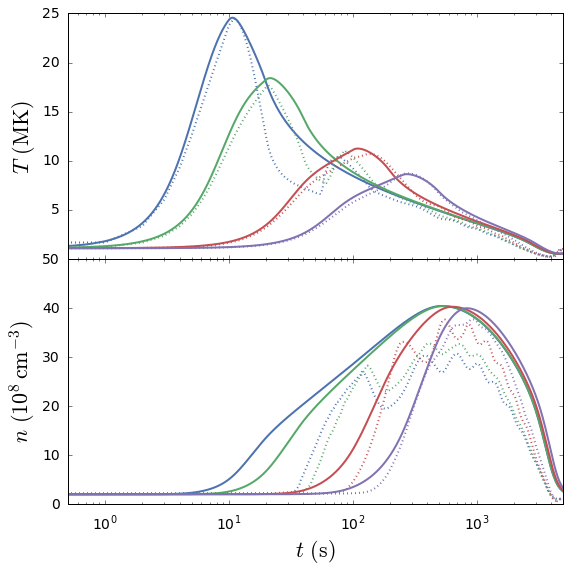

In [13]:
fig,axes = plt.subplots(2,1,figsize=(8,8),sharex=True)
#plotting
for i in range(len(tau_h_results)):
    axes[0].plot(tau_h_results[i]['t'],tau_h_results[i]['T']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    axes[0].plot(hydrad_time,np.array(hydrad_res['single']['tau%ds'%hydrad_labs[i]]['Te'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    axes[1].plot(tau_h_results[i]['t'],tau_h_results[i]['n']/1e+8,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    axes[1].plot(hydrad_time,np.array(hydrad_res['single']['tau%ds'%hydrad_labs[i]]['n'])/1e+8,color=sns.color_palette('deep')[i],
               linestyle='dotted')
#scale
axes[0].set_xscale('log')
axes[1].set_xscale('log')
#limits
axes[0].set_xlim([0.5,5000])
axes[1].set_xlim([0.5,5000])
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,50])
#tick labels
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5,prune='lower'))
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
axes[1].set_xlabel(r'$t$ $\mathrm{(s)}$')
axes[0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
axes[1].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#tighten
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f1a.eps',format='eps',dpi=1000)
plt.show()

### Panel 3

$\mathrm{EM}(T)$  for all pulse durations for EBTEL and HYDRAD for the single-fluid case

Value of the slope for $\tau=20$ $\mathrm{s}$ is b=-4.784879
Value of the slope for $\tau=40$ $\mathrm{s}$ is b=-4.795739
Value of the slope for $\tau=200$ $\mathrm{s}$ is b=-4.183067
Cannot find fit for $\tau=500$ $\mathrm{s}$


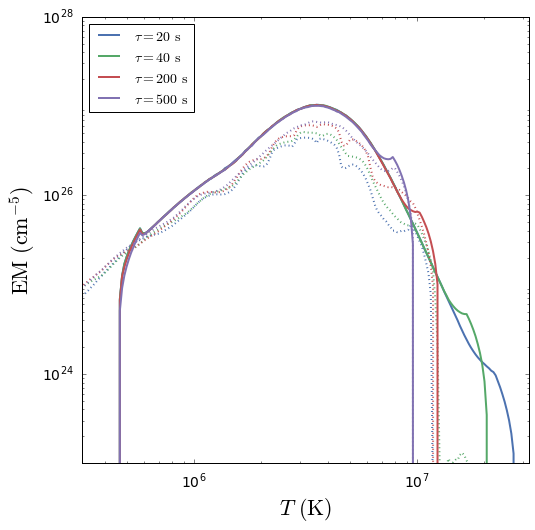

In [14]:
#curve fitting parameters
Ta = np.log10(6e+6)
Tb = np.log10(10e+6)
def pl_func(x,a,b):
    return a + b*x

#plotting/EM distributions
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #EBTEL
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=tau_h_results[i]['t'],temp=tau_h_results[i]['T'],
                           density=tau_h_results[i]['n'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    #Curve Fitting
    logT = np.log10((bin_edges[:-1]+bin_edges[1:])/2)
    logem = np.log10(hist/10)
    T_fit = logT[(logT>=Ta) & (logT<=Tb)]
    em_fit = logem[(logT>=Ta) & (logT<=Tb)]
    try:
        popt,pcov = curve_fit(pl_func,T_fit,em_fit)
        print('Value of the slope for %s is b=%f'%(r'$\tau=%d$ $\mathrm{s}$'%tau_h[i],popt[1]))
        #ax.plot(10**T_fit,10**popt[0]*(10**T_fit)**(popt[1]),color=sns.color_palette('deep')[i],linestyle='dashed')
    except ValueError:
        print('Cannot find fit for %s'%(r'$\tau=%d$ $\mathrm{s}$'%tau_h[i]))
    #HYDRAD
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=hydrad_time,
                           temp=hydrad_res['single']['tau%ds'%hydrad_labs[i]]['Te'],
                           density=hydrad_res['single']['tau%ds'%hydrad_labs[i]]['n'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],linestyle='dotted')
    
#aesthetics
#scale
ax.set_yscale('log')
ax.set_xscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([10**5.5,10**7.5])
#ticks
#x
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$T\,\,\mathrm{(K)}$')
ax.set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
#legend
ax.legend(loc=2)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f1b.eps',format='eps',dpi=1000)
plt.show()

## Figure 2

Single-panel figure showing $\mathrm{EM}(T)$ for differing heat flux models.

Cannot find fit for $f=1$
Cannot find fit for $f=0.53$
Cannot find fit for $f=1/6$
Cannot find fit for $f=0.1$
Value of the slope for $f=1/30$ is b=-2.574509
Cannot find fit for $\mathrm{Spitzer}$


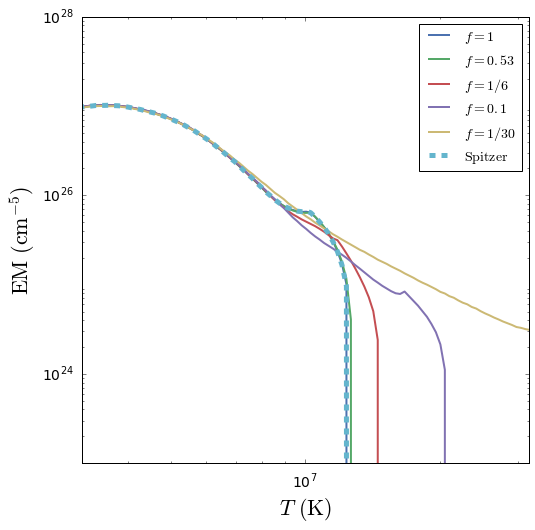

In [15]:
#curve fitting parameters
Ta = 7.0
Tb = 7.5

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(flux_lim_results)):
    #EBTEL
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=flux_lim_results[i]['t'],temp=flux_lim_results[i]['T'],
                           density=flux_lim_results[i]['n'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    if flux_lim[i]['opt']=='classical':
        ls='--'
        lw=5
        marker=''
    else:
        ls = 'solid'
        lw=2
        marker=''
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle=ls,label=flux_lim[i]['flab'],linewidth=lw,marker=marker,markersize=10,markevery=5)
    #Curve fitting
    logT = np.log10((bin_edges[:-1]+bin_edges[1:])/2)
    logem = np.log10(hist/10)
    T_fit = logT[(logT>=Ta) & (logT<=Tb)]
    em_fit = logem[(logT>=Ta) & (logT<=Tb)]
    try:
        popt,pcov = curve_fit(pl_func,T_fit,em_fit)
        print('Value of the slope for %s is b=%f'%(flux_lim[i]['flab'],popt[1]))
        #ax.plot(10**T_fit,10**popt[0]*(10**T_fit)**(popt[1]),color=sns.color_palette('deep')[i],linestyle='dashed')
    except ValueError:
        print('Cannot find fit for %s'%flux_lim[i]['flab'])
    
#aesthetics
#scale
ax.set_yscale('log')
ax.set_xscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([10**6.5,10**7.5])
#ticks
#x
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$T\,\,\mathrm{(K)}$')
ax.set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
#legend
ax.legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f2.eps',format='eps',dpi=1000)
plt.show()

## Figure 3
Temperature, density, and $\mathrm{EM}$ for electron heating. Three panels, same as Fig. 1.

### Panels 1, 2, & 3
Temperature and density as a function of $t$ for electron and ion heating with comparisons to HYDRAD.

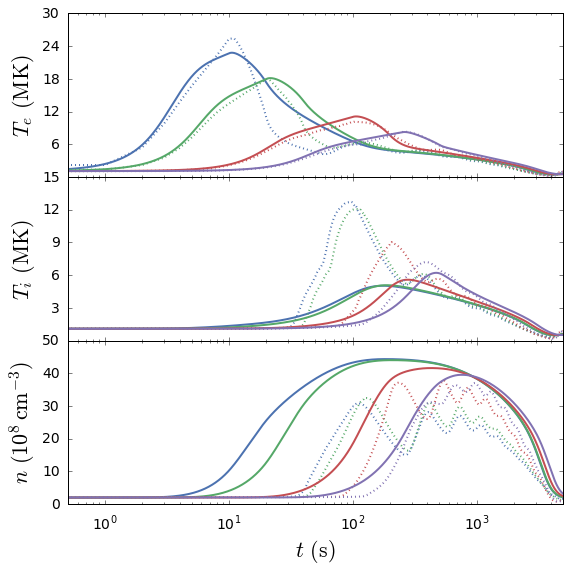

In [16]:
fig,axes = plt.subplots(3,1,figsize=(8,8),sharex=True)
#plotting
for i in range(len(tau_h_results)):
    #electron temperature
    axes[0].plot(tau_h_results[i]['te'],tau_h_results[i]['Tee']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    axes[0].plot(hydrad_time,np.array(hydrad_res['electron']['tau%ds'%hydrad_labs[i]]['Te'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    #ion temperature
    axes[1].plot(tau_h_results[i]['te'],tau_h_results[i]['Tei']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid')
    axes[1].plot(hydrad_time,np.array(hydrad_res['electron']['tau%ds'%hydrad_labs[i]]['Ti'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    #density
    axes[2].plot(tau_h_results[i]['te'],tau_h_results[i]['ne']/1e+8,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    axes[2].plot(hydrad_time,np.array(hydrad_res['electron']['tau%ds'%hydrad_labs[i]]['n'])/1e+8,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    
#scale
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
#limits
axes[0].set_xlim([0.5,5000])
axes[0].set_ylim([0,30])
axes[1].set_xlim([0.5,5000])
axes[1].set_ylim([0,15])
axes[2].set_xlim([0.5,5000])
axes[2].set_ylim([0,50])
#tick labels
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5,prune='lower'))
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5,prune='lower'))
axes[2].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
axes[2].set_xlabel(r'$t$ $\mathrm{(s)}$')
axes[0].set_ylabel(r'$T_e$ $\mathrm{(MK)}$')
axes[1].set_ylabel(r'$T_i$ $\mathrm{(MK)}$')
axes[2].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
#ax.legend()
#tighten
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f3a.eps',format='eps',dpi=1000)
plt.show()

### Panel 4
$\mathrm{EM}(T)$ for electron and ion heating

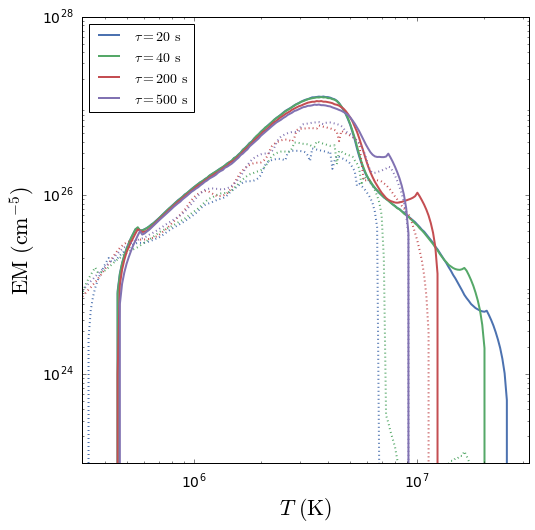

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #EBTEL
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=tau_h_results[i]['te'],temp=tau_h_results[i]['Tee'],
                           density=tau_h_results[i]['ne'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    #HYDRAD
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=hydrad_time,
                           temp=hydrad_res['electron']['tau%ds'%hydrad_labs[i]]['Te'],
                           density=hydrad_res['electron']['tau%ds'%hydrad_labs[i]]['n'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],linestyle='dotted')
    
#aesthetics
#scale
ax.set_yscale('log')
ax.set_xscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([10**5.5,10**7.5])
#ticks
#x
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$T\,\,\mathrm{(K)}$')
ax.set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
#legend
ax.legend(loc=2)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f3b.eps',format='eps',dpi=1000)
plt.show()

## Figure 4

Added an extra figure here in the middle to show the $p(T)$ and $n(T)$ state space for EBTEL two-fluid runs for $\tau=200$ s.

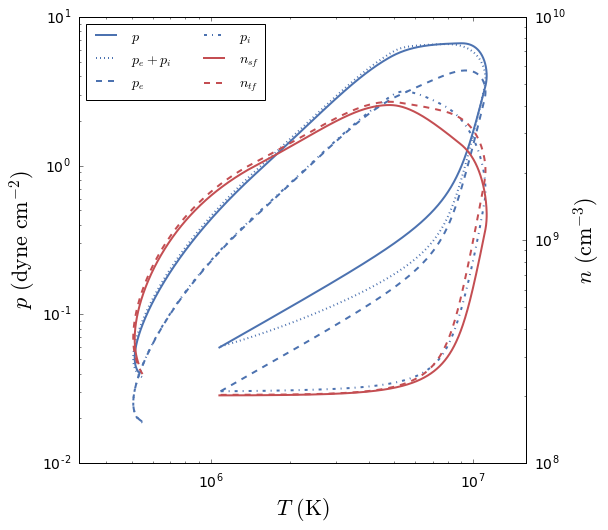

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
axn = ax.twinx()
#total pressure--single fluid
linep = ax.plot(tau_h_results[2]['T'],2.*ac.k_B.cgs.value*tau_h_results[2]['n']*tau_h_results[2]['T'],
       color=sns.color_palette('deep')[0],linestyle='solid',label=r'$p$')
#total pressure--two fluid
linep_tot = ax.plot(tau_h_results[2]['Tee'],
        ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tee']+ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tei'],
       color=sns.color_palette('deep')[0],linestyle='dotted',label=r'$p_e+p_i$')
#electron pressure
linepe = ax.plot(tau_h_results[2]['Tee'],
        ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tee'],
       color=sns.color_palette('deep')[0],linestyle='dashed',label=r'$p_e$')
#ion pressure
linepi = ax.plot(tau_h_results[2]['Tee'],
        ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tei'],
       color=sns.color_palette('deep')[0],linestyle='-.',label=r'$p_i$')
#density--single-fluid
linensf = axn.plot(tau_h_results[2]['T'],tau_h_results[2]['n'],
       color=sns.color_palette('deep')[2],linestyle='solid',label=r'$n_{sf}$')
#density--two-fluid
linentf = axn.plot(tau_h_results[2]['Tee'],tau_h_results[2]['ne'],
       color=sns.color_palette('deep')[2],linestyle='dashed',label=r'$n_{tf}$')
#axes properties
#limits
ax.set_xlim([10**5.5,10**7.2])
axn.set_xlim([10**5.5,10**7.2])
#scale
ax.set_yscale('log')
axn.set_yscale('log')
ax.set_xscale('log')
axn.set_xscale('log')
#labels
ax.set_xlabel(r'$T$ $\mathrm{(K)}$')
ax.set_ylabel(r'$p$ $(\mathrm{dyne}$ $\mathrm{cm}^{-2})$')
axn.set_ylabel(r'$n$ $(\mathrm{cm}^{-3})$')
#legend
lines = linep + linep_tot + linepe + linepi + linensf + linentf
labels = []
[labels.append(l.get_label()) for l in lines]
ax.legend(lines,labels,loc=2,ncol=2)
#show
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f4.eps',format='eps',dpi=1000)
plt.show()

## Figure 5
Three panel figure for ion heating: $n,T,\mathrm{EM}(T)$.

### Panel 1, 2, & 3

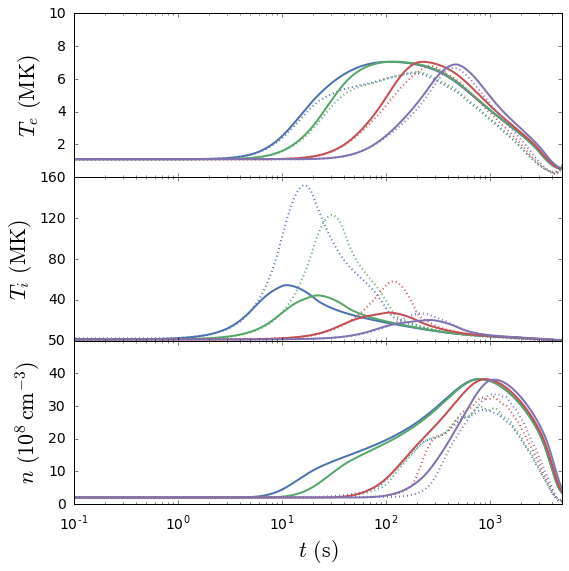

In [19]:
fig,axes = plt.subplots(3,1,figsize=(8,8),sharex=True)
#plotting
for i in range(len(tau_h_results)):
    #electron temperature
    axes[0].plot(tau_h_results[i]['ti'],tau_h_results[i]['Tie']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    axes[0].plot(hydrad_time,np.array(hydrad_res['ion']['tau%ds'%hydrad_labs[i]]['Te'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    #ion temperature
    axes[1].plot(tau_h_results[i]['ti'],tau_h_results[i]['Tii']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid')
    axes[1].plot(hydrad_time,np.array(hydrad_res['ion']['tau%ds'%hydrad_labs[i]]['Ti'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    #density
    axes[2].plot(tau_h_results[i]['ti'],tau_h_results[i]['ni']/1e+8,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    #axes[2].plot(tau_h_results[i]['ti'],tau_h_results[i]['nia']/1e+8,color=sns.color_palette('deep')[i],
    #           linestyle='dashed',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    axes[2].plot(hydrad_time,np.array(hydrad_res['ion']['tau%ds'%hydrad_labs[i]]['n'])/1e+8,color=sns.color_palette('deep')[i],
               linestyle='dotted')
    
#scale
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
#limits
axes[0].set_xlim([0,5000])
axes[0].set_ylim([0,10])
axes[1].set_xlim([0,5000])
axes[1].set_ylim([0,160])
axes[2].set_xlim([0,5000])
axes[2].set_ylim([0,50])
#tick labels
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5,prune='lower'))
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5,prune='lower'))
axes[2].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
axes[2].set_xlabel(r'$t$ $\mathrm{(s)}$')
axes[0].set_ylabel(r'$T_e$ $\mathrm{(MK)}$')
axes[1].set_ylabel(r'$T_i$ $\mathrm{(MK)}$')
axes[2].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
#ax.legend()
#tighten
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f5a.eps',format='eps',dpi=1000)
plt.show()

### Panel 4

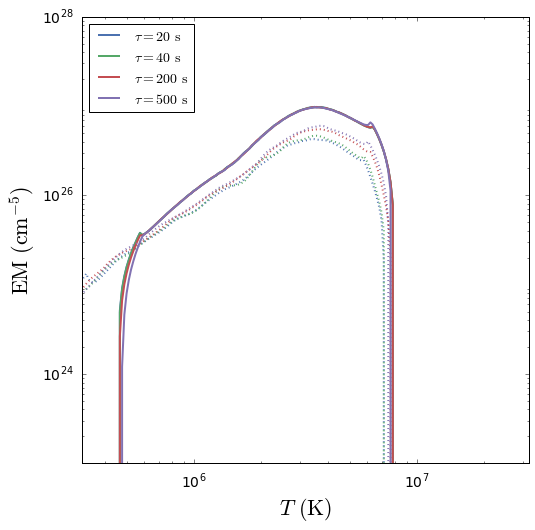

In [20]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #EBTEL
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=tau_h_results[i]['ti'],temp=tau_h_results[i]['Tie'],
                           density=tau_h_results[i]['ni'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    #HYDRAD
    binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=hydrad_time,
                           temp=hydrad_res['ion']['tau%ds'%hydrad_labs[i]]['Te'],
                           density=hydrad_res['ion']['tau%ds'%hydrad_labs[i]]['n'])
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],linestyle='dotted')
    
#aesthetics
#scale
ax.set_yscale('log')
ax.set_xscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([10**5.5,10**7.5])
#ticks
#x
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$T\,\,\mathrm{(K)}$')
ax.set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
#legend
ax.legend(loc=2)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f5b.eps',format='eps',dpi=1000)
plt.show()

## Figure 6

$T(t)$ and $n(t)$ profiles comparing electron, ion, and single cases for both long (500 s) and short (20 s) pulses.

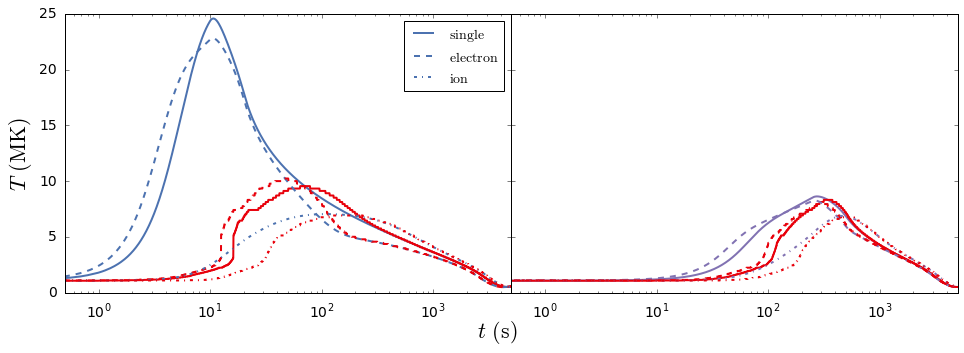

In [21]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
#plotting
#short
ax[0].plot(f6a_single[:,0],f6a_single[:,1]/1e+6,color=sns.color_palette('deep')[0],linestyle='solid',
           label=r'$\mathrm{single}$')
ax[0].plot(f6a_single[:,0],f6a_single[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='solid')
ax[0].plot(f6a_electron[:,0],f6a_electron[:,1]/1e+6,color=sns.color_palette('deep')[0],linestyle='dashed',
           label=r'$\mathrm{electron}$')
ax[0].plot(f6a_electron[:,0],f6a_electron[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='dashed')
ax[0].plot(f6a_ion[:,0],f6a_ion[:,1]/1e+6,color=sns.color_palette('deep')[0],linestyle='-.',
           label=r'$\mathrm{ion}$')
ax[0].plot(f6a_ion[:,0],f6a_ion[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='-.')
#long
ax[1].plot(f6b_single[:,0],f6b_single[:,1]/1e+6,color=sns.color_palette('deep')[3],linestyle='solid',
           label=r'$\mathrm{single}$')
ax[1].plot(f6b_single[:,0],f6b_single[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='solid')
ax[1].plot(f6b_electron[:,0],f6b_electron[:,1]/1e+6,color=sns.color_palette('deep')[3],linestyle='dashed',
           label=r'$\mathrm{electron}$')
ax[1].plot(f6b_electron[:,0],f6b_electron[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='dashed')
ax[1].plot(f6b_ion[:,0],f6b_ion[:,1]/1e+6,color=sns.color_palette('deep')[3],linestyle='-.',
           label=r'$\mathrm{ion}$')
ax[1].plot(f6b_ion[:,0],f6b_ion[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='-.')
#scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#limits
ax[0].set_xlim([0.5,5000])
ax[1].set_xlim([0.5,5000])
ax[0].set_ylim([0,25])
ax[1].set_ylim([0,25])
#tick labels
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#axes labels
ax[0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
fig.text(0.5, 0.015, r'$t$ $\mathrm{(s)}$', ha='center', va='center',fontsize=22)
#legend
ax[0].legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f6.eps',format='eps',dpi=1000)
plt.show()

## Figure 7

Emission measure distribution comparision between $T$ and $T_{eff}$ for some of the cases above.

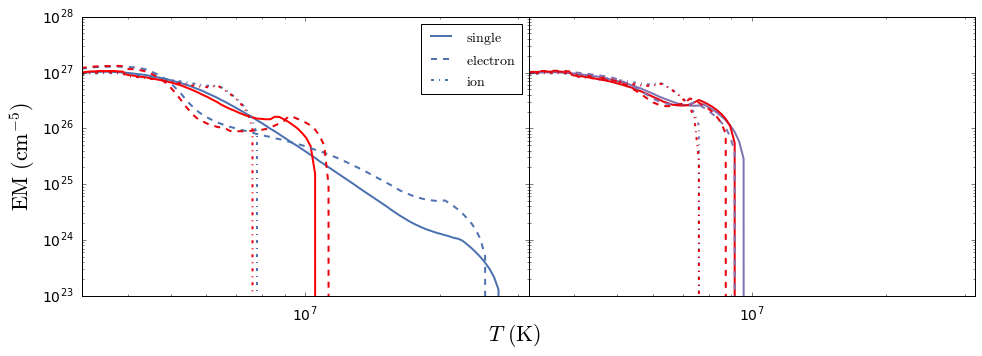

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#short
#single
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6a_single[:,0],temp=f6a_single[:,1],
                       density=f6a_single[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6a_single[:,0],temp=f6a_single[:,2],
                       density=f6a_single[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='solid')
#electron
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6a_electron[:,0],temp=f6a_electron[:,1],
                       density=f6a_electron[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],linestyle='dashed',
            label=r'$\mathrm{electron}$')
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6a_electron[:,0],temp=f6a_electron[:,2],
                       density=f6a_electron[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='dashed')
#ion
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6a_ion[:,0],temp=f6a_ion[:,1],density=f6a_ion[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],linestyle='-.',
            label=r'$\mathrm{ion}$')
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6a_ion[:,0],temp=f6a_ion[:,2],density=f6a_ion[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='-.')
#long
#single
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6b_single[:,0],temp=f6b_single[:,1],density=f6b_single[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[3],linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6b_single[:,0],temp=f6b_single[:,2],density=f6b_single[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='solid')
#electron
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6b_electron[:,0],temp=f6b_electron[:,1],density=f6b_electron[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[3],linestyle='dashed',
            label=r'$\mathrm{electron}$')
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6b_electron[:,0],temp=f6b_electron[:,2],density=f6b_electron[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='dashed')
#ion
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6b_ion[:,0],temp=f6b_ion[:,1],density=f6b_ion[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[3],linestyle='-.',
            label=r'$\mathrm{ion}$')
binner = emb.EM_Binner(2*config_dict['loop_length']*1e+8,time=f6b_ion[:,0],temp=f6b_ion[:,2],density=f6b_ion[:,3])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='-.')
#scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#limits
ax[0].set_xlim([10**6.5,10**7.5])
ax[0].set_ylim([1e+23,1e+28])
ax[1].set_xlim([10**6.5,10**7.5])
ax[1].set_ylim([1e+23,1e+28])
#labels
fig.text(0.5, 0.015, r'${T}\,\,\mathrm{(K)}$', ha='center', va='center',fontsize=22)
ax[0].set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
#legend
ax[0].legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f7.eps',format='eps',dpi=1000)
plt.show()